This notebook reads in (1) skip1 unwrapped igrams from tip of Laguna Salada and (2) raw SLCs to make interferograms so that we can add the 2pi jumps back into the raw data. Uses same algorithm as my unwrapping tool /data/ocp4/LagunaSalada/8_unwrap/filter_1D_profile_and_unwrap.py 

This notebook: <br>
1. Reads in unwrapped skip1 igrams (209 of them), stores them in 3D array. Each slice is a single igram, first dimension is date (first date of igram)
2. Reads in raw SLCs and calculates (full res) skip1 igrams 
3. Calculates the difference btw unwrapped and full res skip1 igrams, adds it back to the full res skip1 igrams (once corrected for edge effects). 
4. Saves the unfiltered, unwrapped skip1 igrams in their own folder in cropped_.../cropped.../unfilt_unwrapped
5. Reads those files in to plot them and test 
6. Plots the unfiltered unwrapped skip1 igram, the unwrapped skip1 igram, and the difference between the two. 

This notebook was written copied and edited on 3-29-23.

***

In [2]:
# import stuff
import os,sys
import glob
import pandas
from osgeo import gdal
import datetime 
from datetime import datetime
from datetime import timedelta
from dateutil import parser
import numpy as np
from scipy.ndimage import gaussian_filter
from scipy.stats import skew
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib  widget

Define directory where igrams are sitting, and where we can pull out the dates to loop through. Define size of files to be read in. 

In [3]:
# igramsDir is where the cropped, unwrapped igrams are 
#igramsDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_northern_shore_LS_for_unwrapping/filt_unwrapped/'
igramsDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_LS_with_western_mtns/filt_unwrapped/'

# this one is to pick out the dates 
datesDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/'
# shape of unwrapped igrams
dx = 3000
dy = 750

#larger area
dx = 4000
dy = 1100

# load in dates, make sure they are in order
dates = [os.path.basename(x) for x in glob.glob(datesDir+"SLC_vh/2*")]; dates = sorted(dates)
nd = len(dates); numIgrams = nd-2 # b/c skip1 igrams 
print(str(numIgrams)+' skip1 igrams.')


209 skip1 igrams.


Read in filtered, unwrapped igrams for calculating 2pi jumps

In [4]:
# make an array to hold igrams
igrams_unwr = np.ndarray((numIgrams,dy,dx),dtype='float')
for i in range(numIgrams):
    # define the 2 dates. 
    date1=dates[i]; date2=dates[i+2]
    # Read in the igram 
    ds = gdal.Open(igramsDir+date1+"_"+date2+"_filt.unw", gdal.GA_ReadOnly)
    #ds = gdal.Open(igramsDir+date1+"_"+date2+"_unwr.int", gdal.GA_ReadOnly)
    igrams_unwr[i] = ds.GetRasterBand(1).ReadAsArray(0,0,dx,dy)
print('filtered unwrapped skip1 igrams loaded.')

filtered unwrapped skip1 igrams loaded.


Load in the section of full res SLCs that matches up to the unwrapped igrams we just loaded in, make full res igrams with them, and save them to array called igrams_full_res

In [5]:
igrams_full_res = np.zeros((np.shape(igrams_unwr)),dtype='float')
igrams_filt = np.zeros((np.shape(igrams_unwr)),dtype='float')
# bounding box
x1 = 17000; x2 = 14000
y1 = 1750;  y2 = 1000

# larger box with western mtns
x1 = 18000
y1 = 2100

# filter by this much 
alooks=4
rlooks=20
# output file size
dx2 = int(np.abs(x1-x2)); print('range: '+str(dx2))
dy2 = int(np.abs(y1-y2)); print('azimuth: '+str(dy2))
print('total number of pixels: '+str(dx2*dy2))
# set the driver first, only do once.
driver=gdal.GetDriverByName('ISCE')
# loop through the dates 
for i in range(numIgrams): # numIgrams if doing all of them at once
    # define the 2 dates. 
    date1=dates[i]
    date2=dates[i+2] # skip1 
    # Read in 2 full SLCs to make interferogram 
    ds = gdal.Open(datesDir+"/SLC_vv/"+date1+"/"+date1+".slc.full", gdal.GA_ReadOnly)
    slc1 = ds.GetRasterBand(1).ReadAsArray(x2,y2,dx2,dy2)
    #print('SLC 1 subsect loaded.')
    ds = gdal.Open(datesDir+"/SLC_vv/"+date2+"/"+date2+".slc.full", gdal.GA_ReadOnly)
    slc2 = ds.GetRasterBand(1).ReadAsArray(x2,y2,dx2,dy2)
    #print('SLC 2 subsect loaded.')
    intTemp = slc1*np.conj(slc2)
    #print(type(intTemp[0,0]))
    igrams_full_res[i] = np.angle(intTemp)
    # filter the full res igrams the same as the way I did to input into SNAPHU in this notebook: 
    #   /data/ocp4/LagunaSalada/1_igrams/extract_ALL_igrams_for_unwrapping.ipynb
    # s1=slc1*np.conj(slc1)
    # s2=slc2*np.conj(slc2)
    # a1r=gaussian_filter(np.real(s1), sigma=[alooks/4,rlooks/4])
    # a1i=gaussian_filter(np.imag(s1), sigma=[alooks/4,rlooks/4])
    # a2r=gaussian_filter(np.real(s2), sigma=[alooks/4,rlooks/4])
    # a2i=gaussian_filter(np.imag(s2), sigma=[alooks/4,rlooks/4])
    # a1 = a1r+1j*a1i
    # a2 = a2r+1j*a2i
    filtimager=gaussian_filter(np.real(intTemp), sigma=[alooks/4,rlooks/4])
    filtimagei=gaussian_filter(np.imag(intTemp), sigma=[alooks/4,rlooks/4])
    filt_intTemp = filtimager+1j*filtimagei
    igrams_filt[i] = np.angle(filt_intTemp)

print('full res skip1 igrams loaded.')
print('full res skip1 igrams filtered for full res unwrapping step.')

range: 4000
azimuth: 1100
total number of pixels: 4400000
full res skip1 igrams loaded.
full res skip1 igrams filtered for full res unwrapping step.


Calculate the difference (in multiples of 2pi radians) between full res and unwrapped. Save the unfiltered, unwrapped results.

In [6]:
# initialize arrays to hold the 2pi jumps, the igrams where jumps are added back in
#moduli_jumps = np.zeros((np.shape(igrams_unwr)),dtype='float')
unwr_full_res = np.zeros((np.shape(igrams_unwr)),dtype='float')

#outputdir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_northern_shore_LS_for_unwrapping/unfilt_unwrapped/'
#outputdir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_LS_with_western_mtns/unfilt_unwrapped/'
outputdir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_LS_with_western_mtns/unfilt_unwrapped/JiangLohmanTest/'

# set the driver first, only do once.
driver=gdal.GetDriverByName('ISCE')

for i in range(numIgrams): # numIgrams
    # # the 2pi jumps that need to be added back into the full res igrams 
    # moduli_jumps[i] = igrams_unwr[i] - igrams_filt[i] # this is same as 'dif' in other script 
    # # the full res igrams with 2pi jumps added back in 
    # unwr_full_res[i] = igrams_full_res[i] + moduli_jumps[i] # this is 'difAdded' in other script 
    # # the remainder in case there are edge effect errors from filtering before unwrapping 
    # rem = np.mod(igrams_unwr[i]-unwr_full_res[i]+np.pi,2*np.pi)-np.pi
    # # subtract out the remainder to correct, put it back into unwrapped full res igrams array 
    # unwr_full_res[i] = igrams_unwr[i] - rem

    # new method: from Jiang and Lohman, 2021
    unwr_full_res[i] = np.angle(np.exp(1j*igrams_full_res[i]) * np.conj(np.exp(1j*igrams_filt[i]))) + igrams_unwr[i] 

    # define the 2 dates. 
    date1=dates[i]
    date2=dates[i+2] # skip2 
    # save the unfiltered, unwrapped igrams 
    igramFile = date1+'_'+date2+'_unfilt.unw'
    colds = driver.Create(outputdir+igramFile,dx2,dy2,1,gdal.GDT_Float32)
    colds.GetRasterBand(1).WriteArray(unwr_full_res[i])
    colds=None

print('full res unwrapped skip1 igrams created and saved (Version 2).')

full res unwrapped skip1 igrams created and saved (Version 2).


Read in the files above so I can plot one at a time to make sure they saved correctly and look right. 

In [7]:
# set the driver first, only do once.
driver=gdal.GetDriverByName('ISCE')
unwr_full_res = np.ndarray((numIgrams,dy,dx),dtype='float')
outputdir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_LS_with_western_mtns/unfilt_unwrapped/'

# loop through the dates 
for i in range(numIgrams): # numIgrams if doing all of them at once
    # define the 2 dates. 
    date1=dates[i]
    date2=dates[i+2] # skip1 igrams
    igramFile = outputdir+date1+'_'+date2+'_unfilt.unw'
    ds = gdal.Open(igramFile, gdal.GA_ReadOnly)
    unwr_full_res[i] = ds.GetRasterBand(1).ReadAsArray(0,0,dx,dy)

Now plot the interferogram: filtered version, the unfiltered unwrapped version, the difference between the two, and the raw interferogram (wrapped).

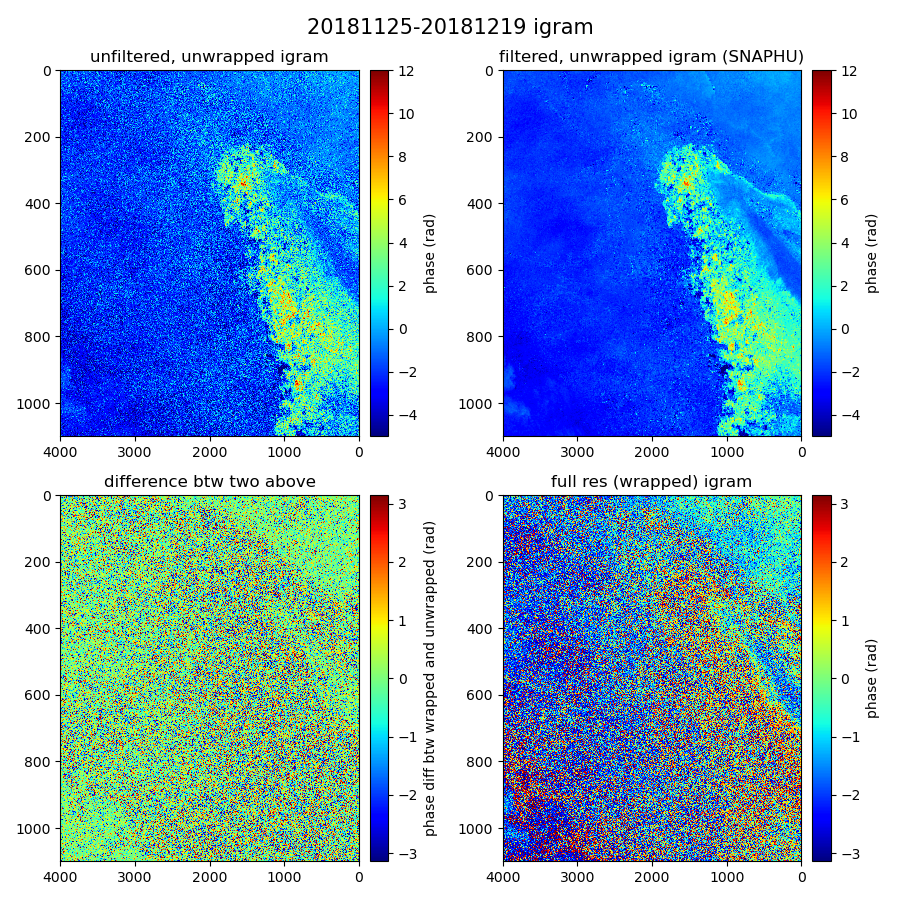

In [11]:
k = 46 # which igram to plot? 
date1 = dates[k]; date2 = dates[k+2] # skip1 igram
plt.figure(figsize=(9,9),tight_layout=True) # for poster: figsize=(72/12+1,65/12)

plt.subplot(2,2,1)
plt.imshow(unwr_full_res[k],aspect='auto',interpolation='nearest',extent=[0,dx,dy,0],vmin=-5,vmax=12)
plt.colorbar(orientation='vertical',pad=0.03,label='phase (rad)'); plt.set_cmap('jet')
plt.xlim([dx,0]); plt.ylim([dy,0])
plt.title('unfiltered, unwrapped igram')

plt.subplot(2,2,2)
plt.imshow(igrams_unwr[k],aspect='auto',interpolation='nearest',extent=[0,dx,dy,0],vmin=-5,vmax=12)
plt.colorbar(orientation='vertical',pad=0.03,label='phase (rad)'); plt.set_cmap('jet')
plt.xlim([dx,0]); plt.ylim([dy,0])
plt.title('filtered, unwrapped igram (SNAPHU)')

plt.subplot(2,2,3)
plt.imshow(igrams_unwr[k]-unwr_full_res[k],aspect='auto',interpolation='nearest',extent=[0,dx,dy,0])
plt.colorbar(orientation='vertical',pad=0.03,label='phase diff btw wrapped and unwrapped (rad)'); plt.set_cmap('jet')
plt.xlim([dx,0]); plt.ylim([dy,0])
plt.title('difference btw two above')

plt.subplot(2,2,4)
plt.imshow(igrams_full_res[k],aspect='auto',interpolation='nearest',extent=[0,dx,dy,0])
plt.colorbar(orientation='vertical',pad=0.03,label='phase (rad)'); plt.set_cmap('jet')
plt.xlim([dx,0]); plt.ylim([dy,0])
plt.title('full res (wrapped) igram')

plt.suptitle(str(date1)+'-'+str(date2)+' igram',fontsize=15)
plt.show()

In [ ]:
k = 72
date1 = dates[k]; date2 = dates[k+2] # skip1 
plt.figure(figsize=(6,5.5),tight_layout=True) 
plt.imshow(unwr_full_res[k],aspect='auto',interpolation='nearest',extent=[0,dx,dy,0],vmin=-5,vmax=12)
plt.colorbar(orientation='vertical',pad=0.03,label='phase (rad)'); plt.set_cmap('jet')
plt.xlim([dx,0]); plt.ylim([dy,0])
plt.xticks([]); plt.yticks([])
plt.title('unfilt, unw skip1 igram, '+str(date1)+'-'+str(date2))
plt.show()